In [6]:
import skopt
from skopt.plots import plot_objective
from utils import *
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc("text", usetex=False)

def objective(**params):
    pass

def callback(result):
    pass

result = skopt.load('../output/skopt.pt')

<Figure size 640x480 with 0 Axes>

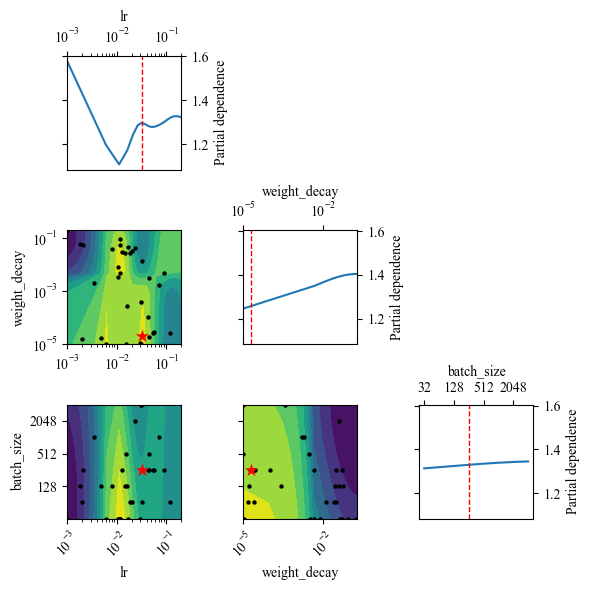

In [7]:
plt.figure()
ax = plot_objective(result)
plt.show()

In [8]:
ax[0, 0].get_lines()[0].set_color('k')

In [9]:
result.x

[0.032242419603472044, 1.975586883089572e-05, 256]

In [10]:
result.fun

0.8956718444824219